In [1]:
%load_ext autoreload
%autoreload 2

import ex4
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#### 1. Align consecutive frames
    a. Lucas Kanade or Point Correspondences, you choose
    b. Create a transformation matrix for every two consecutive frames
    c. Debug: Use synthetic videos: no motion, simple translation,

40+u:60+u =(41, 62), 40+v:60+v =(41, 62)
Expected shift: u=1, v=2


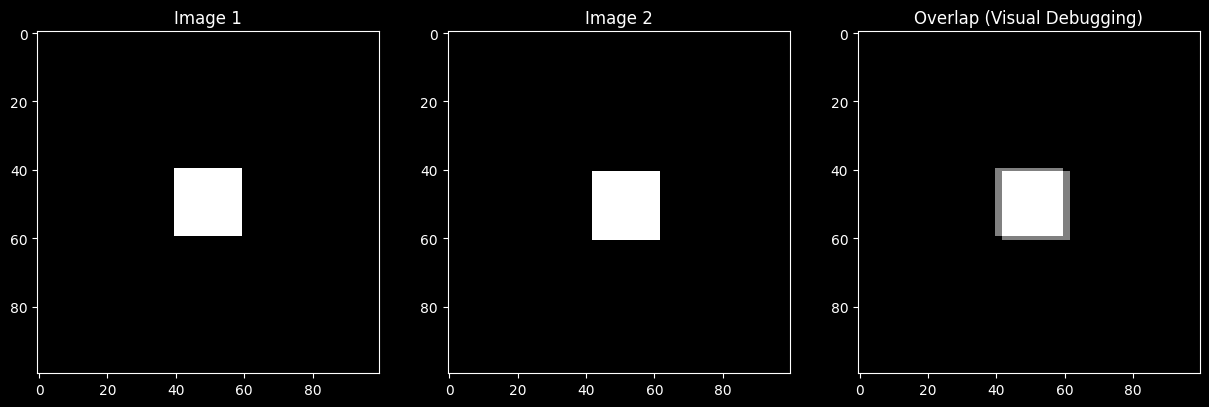

In [41]:
im1 = np.zeros((100, 100))
im1[40:60, 40:60] = 1
im2 = np.zeros((100, 100))
u,v = 1,2
im2[40+u:60+u, 40+v:60+v] = 1 # Shifted by 1 pixel
print(f"40+u:60+u ={40+u,60+v}, 40+v:60+v ={40+u,60+v}")
# print("diff is: ",abs(40+u - (60+v)))
# 2. Plotting side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns
# Image 1
axes[0].imshow(im1, cmap='gray')
axes[0].set_title("Image 1")
# Image 2
axes[1].imshow(im2, cmap='gray')
axes[1].set_title("Image 2")
# Overlap
axes[2].imshow(im1 + im2, cmap='gray')
axes[2].set_title("Overlap (Visual Debugging)")

# axes.imshow(im1 + im2, cmap='gray')
print(f"Expected shift: u={u}, v={v}")
# plt.show()

In [42]:
u2, v2, theta = ex4.lucas_kanade_step(im1, im2, 3)
print(f"Calculated shift: u={u2}, v={v2}, theta={theta}")

Calculated shift: u=0.9463027403218791, v=0.903697259678121, theta=0.007394519356241845


In [55]:
import numpy as np
import ex4
from scipy.ndimage import shift, gaussian_filter, rotate

# 1. Setup specific shifts
expected_u = 0.1  # Horizontal shift (x)
expected_v = 0.2  # Vertical shift (y)
expected_theta = 0.0 # No rotation for this test

# 2. Create rich texture image (Smoothed Noise)
# Using a slightly larger image helps distinguish rotation from translation
im1 = np.random.rand(150, 150)
im1 = gaussian_filter(im1, sigma=2.0)

# 3. Apply Shift accurately
# Note: scipy shift takes (axis_0_shift, axis_1_shift) -> (v, u)
im2 = shift(im1, shift=[expected_v, expected_u], order=3)
# 4. Run your Rigid LK
u_calc, v_calc, theta_calc = ex4.lucas_kanade_step(im1, im2, border_cut=10)

print(f"Expected: u={expected_u}, v={expected_v}, theta=0")
print(f"Got:      u={u_calc:.4f}, v={v_calc:.4f}, theta={theta_calc:.6f}")

# 5. Analysis
error_trans = np.sqrt((u_calc - expected_u)**2 + (v_calc - expected_v)**2)
print(f"Translation Error: {error_trans:.4f}")

if error_trans < 0.1 and abs(theta_calc) < 0.01:
    print("✅ SUCCESS: Axis logic and Solver are correct.")
else:
    print("❌ FAIL: Still a mismatch. Check matrix construction.")

Expected: u=0.1, v=0.2, theta=0
Got:      u=0.1054, v=0.2109, theta=0.000004
Translation Error: 0.0122
✅ SUCCESS: Axis logic and Solver are correct.


In [66]:
import numpy as np
import ex4
from scipy.ndimage import shift, gaussian_filter, rotate

# 1. Define Transformation
# Let's try a realistic scenario for video stabilization:
expected_u = 0.1       # Translation x
expected_v = -0.2      # Translation y
expected_deg = 0.5     # Rotation in Degrees (Small rotation)

# Convert to radians for comparison with our algorithm output
expected_theta = np.deg2rad(expected_deg)

# 2. Create Image
im1 = np.random.rand(150, 150)
im1 = gaussian_filter(im1, sigma=2.0)

# 3. Apply Transformations (Scipy style)
# Order matters! Usually rotation happens around center, then translation.
# reshape=False keeps the image size 200x200 (crops corners)
im_rot = rotate(im1, angle=expected_deg, reshape=False, order=3)
im2 = shift(im_rot, shift=[expected_v, expected_u], order=3)

# 4. Run Optical Flow (Pyramids)
# Note: Increasing window size slightly (to 7 or 9) can help with rotation
u_calc, v_calc, theta_calc = ex4.lucas_kanade_step(im1, im2, 10)

# 5. Compare Results
print(f"--- Translation ---")
print(f"Expected (u, v): ({expected_u}, {expected_v})")
print(f"Got      (u, v): ({u_calc:.4f}, {v_calc:.4f})")

print(f"\n--- Rotation ---")
print(f"Expected (rad): {expected_theta:.6f}  (approx {expected_deg} deg)")
print(f"Got      (rad): {theta_calc:.6f}  (approx {np.rad2deg(theta_calc):.4f} deg)")

# 6. Success Logic
err_trans = np.sqrt((u_calc - expected_u)**2 + (v_calc - expected_v)**2)
err_rot = abs(theta_calc - expected_theta)

print(f"\nErrors -> Trans: {err_trans:.4f}, Rot: {err_rot:.4f}")

if err_trans < 0.2 and err_rot < 0.01:
    print("✅ SUCCESS: The algorithm handles both Rotation and Translation!")
else:
    print("❌ FAIL: Deviations are too large.")

--- Translation ---
Expected (u, v): (0.1, -0.2)
Got      (u, v): (0.1094, -0.2098)

--- Rotation ---
Expected (rad): 0.008727  (approx 0.5 deg)
Got      (rad): 0.009041  (approx 0.5180 deg)

Errors -> Trans: 0.0136, Rot: 0.0003
✅ SUCCESS: The algorithm handles both Rotation and Translation!


#### 2. Stabilize Rotations & Y translations
    a. Debug: Use synthetic videos: no motion, simple translation, rotation...
    b. Create - warp frames to get a stable video (only horizontal motion)

#### 3. Use motion composition to align all frames to same coordinates.
    a. Compute canvas size from motion matrices
    b. Create - paste aligned frames into canvas on top of each other


#### 4. Create mosaic by pasting strips using correct width & location
    a. Start with synthetic videos at constant translation & no rotation...
    b. Back Warping from canvas to frame...


#### 5. Set convergence point (With no setting - this is infinity)
    a. Depth point that does not move between mosaics